In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from polyvore_dataset import categoryDataset
from sklearn import metrics
import torch.nn.functional as F
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
%matplotlib inline

In [2]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor()
])
img = Image.open('./cat_dog.png').convert('RGB')
img = transform(img)
img = img.unsqueeze(0)
img.requires_grad=True

In [3]:
    gradient = None
    model = models.resnet152(pretrained=True)
    
    # Register hook to the first layer
    def hook_function(module, grad_in, grad_out):
        global gradient
        gradient = grad_in[0]

    first_layer = list(model.modules())[1]
    first_layer.register_backward_hook(hook_function)

    #Updates relu activation functions so that it only returns positive gradients
    def relu_hook_function(module, grad_in, grad_out):
        """
        If there is a negative gradient, changes it to zero
        """
        if isinstance(module, nn.ReLU):
            return (torch.clamp(grad_in[0], min=0.0),)
    # Loop through layers, hook up ReLUs with relu_hook_function
    for module in model.modules():
        if isinstance(module, nn.ReLU):
            module.register_backward_hook(relu_hook_function)

    # Forward
    out = model(img)
    model.zero_grad()
    one_hot = torch.FloatTensor(1, out.size()[-1]).zero_()
    one_hot[0][243] = 1

    # Backward
    out.backward(gradient=one_hot, retain_graph=True)

In [4]:
# Get guided backpropagation

def guided_backprop(target_class=243, img=img, model='resnet152'):
    """
    Return:
        gradient: gradient map with the same size as img.
    """
    gradient = None
    model = models.resnet152(pretrained=True)
    model.eval()
    
    # Register hook to the first layer
    def hook_function(module, grad_in, grad_out):
        nonlocal gradient
        gradient = grad_in[0]

    first_layer = list(model.modules())[1]
    first_layer.register_backward_hook(hook_function)

    #Updates relu activation functions so that it only returns positive gradients
    def relu_hook_function(module, grad_in, grad_out):
        """
        If there is a negative gradient, changes it to zero
        """
        if isinstance(module, nn.ReLU):
            return (torch.clamp(grad_in[0], min=0.0),)
    # Loop through layers, hook up ReLUs with relu_hook_function
    for module in model.modules():
        if isinstance(module, nn.ReLU):
            module.register_backward_hook(relu_hook_function)

    # Forward
    out = model(img)
    model.zero_grad()
    one_hot = torch.FloatTensor(1, out.size()[-1]).zero_()
    one_hot[0][target_class] = 1

    # Backward
    out.backward(gradient=one_hot, retain_graph=True)
    
    return gradient.data.numpy().squeeze()

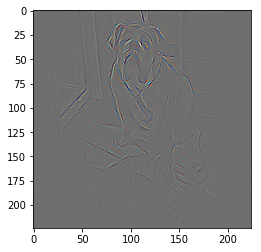

In [5]:
# Visualize Guided_backprop
grad = guided_backprop()
grad = grad - grad.min()
grad /= grad.max()
grad = np.uint8(grad * 255).transpose(1, 2, 0)
plt.imshow(grad)

In [6]:
# Grad-CAM
def grad_cam(target_class=243, img=img, model='resnet152', target_layer='layer4.2'):
    target_layer = target_layer
    feat_map = None
    grad = None 
    model = models.resnet152(pretrained=True)
    model.eval()
    
    # Register hook for feature map
    def func_f(module, input, output):
        nonlocal feat_map
        feat_map = output.detach()

    # Register hook for gradients on target layer
    def func_b(module, grad_in, grad_out):
        nonlocal grad
        grad = grad_out[0].detach()

    for m in model.named_modules():
        if m[0] == target_layer:
            m[1].register_forward_hook(func_f)
            m[1].register_backward_hook(func_b)
            
    out = model(img)
    one_hot = torch.FloatTensor(1, out.size()[-1]).zero_()
    one_hot[0][target_class] = 1

    model.zero_grad()
    out.backward(gradient=one_hot, retain_graph=True)
    
    guided_gradients = grad[0].data.numpy()
    # Get convolution outputs
    target = feat_map[0].data.numpy()
    # Get weights from gradients
    weights = np.mean(guided_gradients, axis=(1, 2))  # Take averages for each gradient
    # Create empty numpy array for cam
    cam = np.ones(target.shape[1:], dtype=np.float32)
    # Multiply each weight with its conv output and then, sum
    for i, w in enumerate(weights):
        cam += w * target[i, :, :]
    cam = cv2.resize(cam, (224, 224))
    cam = np.maximum(cam, 0)
    cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))  # Normalize between 0-1
    cam = np.uint8(cam * 255)  # Scale between 0-255 to visualize
    
    return cam

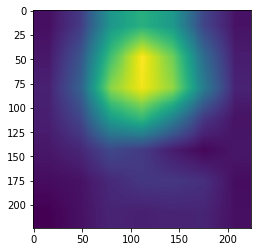

In [7]:
cam = grad_cam()
plt.imshow(cam)

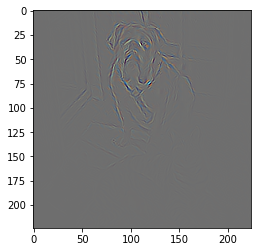

In [8]:
cam = grad_cam()
grad = guided_backprop()
guided_cam = np.multiply(cam, grad)

guided_cam = guided_cam - guided_cam.min()
guided_cam /= guided_cam.max()
guided_cam = np.uint8(guided_cam * 255).transpose(1, 2, 0)
plt.imshow(guided_cam)